In [19]:
# coding: utf-8

# In[1]:

#from pysimplesoap.client import SoapClient
from suds.client import Client
from datetime import datetime
import pytz
import untangle
import pandas as pd
import numpy as np
# import folium
import geopandas as gpd
from shapely.geometry import Point
import fire
get_ipython().magic('matplotlib inline')

In [2]:
class utils(object):
    def event_client_datetime(event, tz_server, tz_client='Europe/Amsterdam'):
        """
        Get datetime object in client time of an XML Element named event with attributes date and time
        input:
        event     : XML Element named event [eg: obj.TimeSeries.series.event[0]]
        tz_server : datetime abbreviation of the server timezone [eg: 'Etc/GMT']
        tz_client : datetime abbreviation of the client timezone [eg: 'Europe/Amsterdam']

        return
        event_client_time : an datetime object of the event in client timezome

        """    
        # convert XML element date string to integer list
        event_server_date = list(map(int, event['date'].split('-'))) # -> [yyyy, MM, dd]
        event_server_time = list(map(int, event['time'].split(':'))) # -> [HH, mm, ss]

        # define server time
        server_time = datetime(event_server_date[0], event_server_date[1], event_server_date[2], 
                               event_server_time[0], event_server_time[1], event_server_time[2], 
                               tzinfo=pytz.timezone(tz_server))    
        client_timezone = pytz.timezone(tz_client)

        # returns datetime in the new timezone
        event_client_time = server_time.astimezone(client_timezone)     

        return event_client_time   

In [11]:


# In[2]:

     


# In[27]:

class fewsPi(object):
    """class with all fews Pi modules"""            
    def getLocations(self, piService, filterId, piVersion='', clientId=''):
        # create the service input xml
        #self.getSoapClient(piService=piService)
        self.client = Client(piService)
        getLocations = self.client.factory.create('getLocations')
        
        # check query to execute for pi version
        if piVersion in {'1.22',''}:
            # execute the query
            getLocations_response = self.client.service.getLocations(clientId = clientId, 
                                                                     filterId = filterId, 
                                                                     piVerson = piVersion)
        
            # parse XML object
            obj = untangle.parse(getLocations_response)

            rows_latlon_list = []
            # get geoDatum
            geoDatum = obj.Locations.geoDatum.cdata
            # get locations
            for location in obj.Locations.location:    
                rows_latlon_list.append({'locationId':location['locationId'],
                                         'shortName':location.shortName.cdata,
                                         'Lat':float(location.lat.cdata),
                                         'Lon':float(location.lon.cdata),
                                         'x':float(location.x.cdata),
                                         'y':float(location.y.cdata)
                                        })

            # CREATE dataframe of location rows dictionary
            df_latlon = pd.DataFrame(rows_latlon_list)

            # CONVERT to geodataframe using latlon for geometry
            geometry = [Point(xy) for xy in zip(df_latlon.Lon, df_latlon.Lat)]
            df = df_latlon.drop(['Lon', 'Lat'], axis=1)
            crs = {'init': 'epsg:4326'}
            gdf2json = gpd.GeoDataFrame(df_latlon, crs=crs, geometry=geometry).to_json()        
        return gdf2json
    
    def getTimeZoneId(self, piService):   
        self.client = Client(piService)
        timeZoneId = self.client.service.getTimeZoneId()
        return timeZoneId
    
    def getTimeseries(self, piService, moduleInstanceIds = 'pr.Reizen.vdLee.baggeracties',
                      locationIds = ['bv.1.7.2.1.1','bv.1.7.2.3.2'], parameterIds = 'k.m3.gebaggerd.vdlee',
                      startTime = '2016-08-01T02:00:00.0+02:00', endTime = '2017-02-01T01:00:00.0+01:00',
                      convertDatum = 'false', omitMissing = 'false', onlyHeaders = 'false', 
                      filterId = None, piVersion='1.22', clientId=''):
        """
        This function can get timeseries from a fews Pi webservice. The following input parameters
        are available:
        
        Parameters
        ----------
        piService : str
            URL to the accessible wsdl FEWS piService (eg. 'http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl')
        moduleInstanceIds : str
            name of the module used in FEWS (eg. 'pr.Reizen.vdLee.baggeracties')
        locationIds : str or list of strings
            name of the location(s) (eg. ['bv.1.7.2.1.1','bv.1.7.2.3.2'])
        parameterIds : str or list of strings
            name of the parameter(s) (eg. 'k.m3.zandwinning.vdlee')
        startTime : str        
            start time in iso format plus timezone (eg. '2016-08-01T02:00:00.0+02:00')
        endTime : str
            end time in iso format plus timezone (eg. '2017-02-01T02:00:00.0+01:00')
        convertDatum : str (boolean)
            standard is 'false'
        omitMissing : str (boolean)
            standard is 'false'
        onlyHeaders : str (boolean)
            standard is 'false'
        filterId : str 
            standard is None
        piVersion : str
            current default is '1.22'
        clientId : str
            current default is ''            
        """
        
        self.client = Client(piService)
        
        # set timeZoneId
        self.timeZoneId = self.getTimeZoneId(piService)
        
        getTimeSeries = self.client.factory.create('getTimeSeries')

        # check query to execute for pi version
        if piVersion in {'1.22',''}:        
            # fill in the query parameters
            getTimeSeries.queryParams.convertDatum = convertDatum
            getTimeSeries.queryParams.omitMissing = omitMissing
            getTimeSeries.queryParams.onlyHeaders = onlyHeaders
            getTimeSeries.queryParams.moduleInstanceIds = moduleInstanceIds
            getTimeSeries.queryParams.locationIds = locationIds
            getTimeSeries.queryParams.parameterIds = parameterIds
            getTimeSeries.queryParams.startTime = startTime#'2016-08-01 02:00'
            getTimeSeries.queryParams.endTime = endTime#'2017-04-01 02:00'
            getTimeSeries.queryParams.version = piVersion

            # execute the query            
            getTimeSeries_response = self.client.service.getTimeSeries(getTimeSeries.queryParams)
            
            obj = untangle.parse(getTimeSeries_response)
            
            # empty dictionary to fill with dictionary format of each row
            # method adopted to avoid appending to pandas dataframe
            event_attributes = ['value','flag']
            rows_ts_dict = {}
            rows_latlon_list = []

            # start iteration
            for series in obj.TimeSeries.series:
                # initiate empty lists
                moduleInstanceId = []
                locationId = []

                stationName= []
                parameterId = []

                event_datetimes = []
                event_values = []
                event_flags = []    

                # collect metadata        
                # GET moduleInstanceId
                try:
                    moduleInstanceId.append(series.header.moduleInstanceId.cdata)
                except AttributeError as e:
                    print ('warning:',e)

                # GET locationId 
                try:
                    locationId.append(series.header.locationId.cdata)
                except AttributeError as e:
                    print ('warning:',e)

                # GET lat
                try:
                    lat = float(series.header.lat.cdata)
                except AttributeError as e:
                    print ('warning:',e)        

                # GET lon
                try:
                    lon = float(series.header.lon.cdata)
                except AttributeError as e:
                    print ('warning:',e)                

                # GET stationNames
                try:
                    stationName.append(series.header.stationName.cdata)
                except AttributeError as e:
                    print ('warning:',e)          

                # GET parameterId    
                try:
                    parameterId.append(series.header.parameterId.cdata + ' (' + series.header.units.cdata + ')')
                except AttributeError as e:
                    print ('warning:',e)

                # GET data values    
                for event in series.event:                    
                    event_datetimes.append( utils.event_client_datetime(event, tz_server='Etc/'+ self.timeZoneId, tz_client='Asia/Yangon'))
                    event_values.append( float(event['value']))
                    event_flags.append( int(event['flag']))

                # PUT timeseries info into row dictionary
                dataValuesFlags = [event_values,event_flags]
                multiColumns = pd.MultiIndex.from_product([moduleInstanceId, parameterId, locationId, event_attributes], names=['moduleInstanceIds','parameterIds','locationIds','event_attributes'])
                df_ts_dict = pd.DataFrame(dataValuesFlags,index=multiColumns, columns=event_datetimes).T.to_dict()

                # PUT timeseries row in dictionary of rows
                rows_ts_dict.update(df_ts_dict)

            #     # PUT latlon/location info into row dictionary
            #     df_latlon_dict = pd.DataFrame([{'stationName':stationName[0],'lat':lat,'lon':lon}]).to_dict(orient='split')
            #     print (df_latlon_dict)

                # PUT latlon/location row in dictionary of rows
                rows_latlon_list.append({'stationName':stationName[0],'Lat':lat,'Lon':lon})

            # CREATE dataframe of timeseries rows dictionary
            df_timeseries = pd.DataFrame(rows_ts_dict)
            
            # reset the multiIndex and create a stacked DataFrame and convert to row-oriented JSON object
            #df_timeseries = df_timeseries.stack([0,1,2]).rename_axis(['date','moduleId','parameterId','locationId'])
            #df2json = df_timeseries.reset_index().to_json(orient='records', date_format='iso')

#             # CREATE dataframe of location rows dictionary
#             df_latlon = pd.DataFrame(rows_latlon_list)

#             # CONVERT latitude longitude to geometry points
#             geometry = [Point(xy) for xy in zip(df_latlon.Lon, df_latlon.Lat)]
#             df_latlon = df_latlon.drop(['Lon', 'Lat'], axis=1)
#             crs = {'init': 'epsg:4326'}
#             gdf_latlon = gpd.GeoDataFrame(df_latlon, crs=crs, geometry=geometry).to_json()

            return df_timeseries#df2json
            
    
#if __name__ == '__main__':
#    fire.Fire(fewsPi)

# test scripts
#>python fewsPiParser.py getTimeseries --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl' --locationIds='bv.1.7.2.1.1'
#>python fewsPiParser.py getLocations --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl' --filterId='f_werk.1'
#>python fewsPiParser.py getTimeZoneId --piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl'

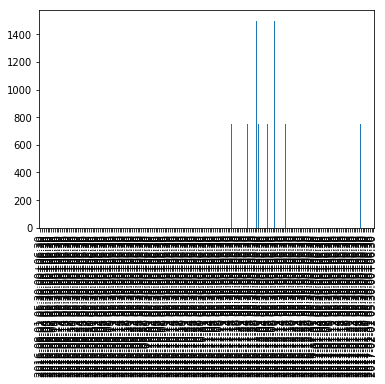

In [31]:
fPi = fewsPi()
locationId = 'bv.1.7.3.1.3'
parameterId = 'k.m3.gebaggerd.vdlee'
# get the dataframe
df = fPi.getTimeseries(piService='http://www.oms-waddenzee.nl:8081/FewsPiService/fewspiservice?wsdl', locationIds=locationId,parameterIds=parameterId)
# replace -999.0 and set as null values
df.replace(-999.0,np.NaN, inplace=True)
# plot
df['pr.Reizen.vdLee.baggeracties']['k.m3.gebaggerd.vdlee (m3)'][locationId]['value'].plot(kind='bar')

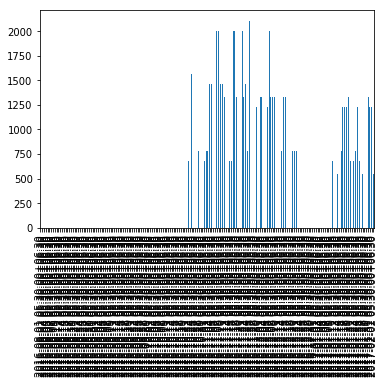